# Chessformer - Preliminary data analysis

## Imports

In [30]:
# @title Imports {display-mode: "form"}
%matplotlib inline
import dask
import dask.dataframe as dd
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyarrow as pa
import pandas as pd
import os

from dask.distributed import Client

_ = dask.config.set(scheduler="threads")

In [2]:
client = Client(n_workers=4, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56763,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56774,Total threads: 2
Dashboard: http://127.0.0.1:56778/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56766,


## Data analysis

### Overall

In [3]:
data = dd.read_parquet(
    path="data/headers/*.parquet.zstd",
    compression="zstd"
)
data = data[(data["WhiteElo"] > 0) & (data["BlackElo"] > 0)]
print(data.dtypes)
data.head(10)

Event          category
Result         category
WhiteElo         uint16
BlackElo         uint16
TimeControl    category
Termination    category
dtype: object


,Event,Result,WhiteElo,BlackElo,TimeControl,Termination
0,Rated Classical game,1-0,1639,1403,600+8,Normal
1,Rated Classical game,1-0,1654,1919,480+2,Normal
2,Rated Classical game,1-0,1643,1747,420+17,Normal
3,Rated Bullet game,0-1,1824,1973,60+1,Normal
4,Rated Bullet game,0-1,1765,1815,60+1,Normal
5,Rated Blitz game,1-0,1477,1487,300+3,Time forfeit
6,Rated Blitz game,0-1,1541,1500,300+0,Normal
7,Rated Classical game,1-0,1765,1752,540+0,Normal
8,Rated Classical game,1-0,1445,1169,900+0,Normal
9,Rated Blitz game,0-1,1522,1428,180+5,Normal


In [4]:
event_types_frequencies = data["Event"].value_counts().compute()
event_types_frequencies.head(7)

Event
Rated Blitz game             2046867409
Rated Bullet game            1510619343
Rated Rapid game              578621014
Rated Classical game          114307846
Rated UltraBullet game         29005219
Rated Standard game            17081459
Rated Correspondence game      11358303
Name: count, dtype: int64

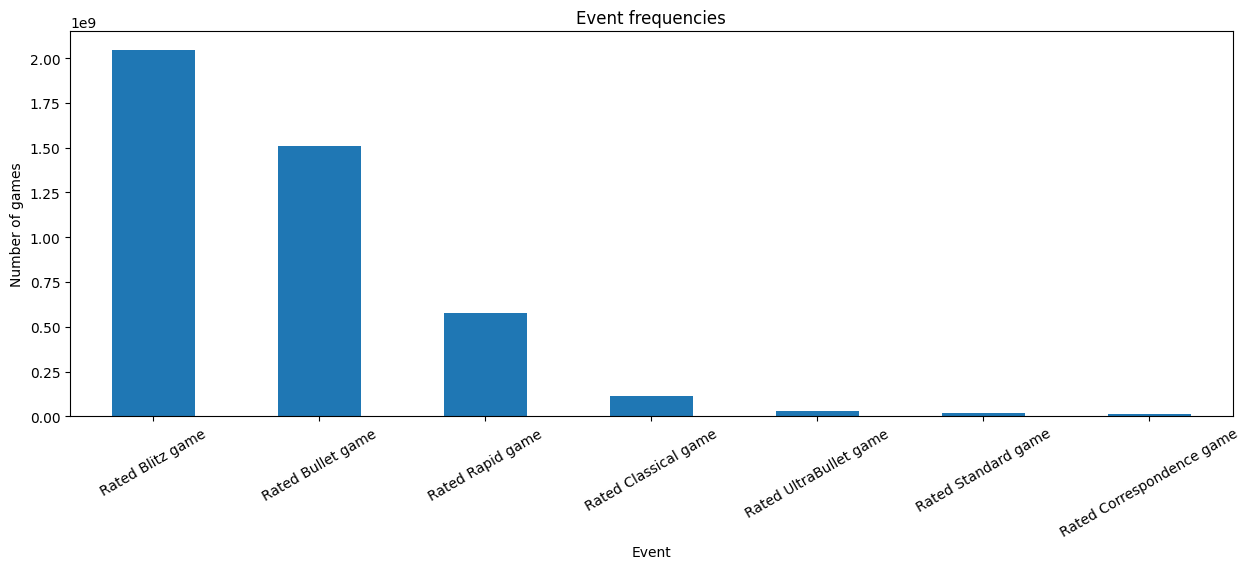

In [8]:
axis = event_types_frequencies.head(7).plot.bar("bar", figsize=(15, 5))
plt.title("Event frequencies")
plt.xlabel("Event")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

In [4]:
blitz_games = data[data["Event"] == "Rated Blitz game"].drop(columns=["Event"])
blitz_games.head()

,Result,WhiteElo,BlackElo,TimeControl,Termination
5,1-0,1477,1487,300+3,Time forfeit
6,0-1,1541,1500,300+0,Normal
9,0-1,1522,1428,180+5,Normal
13,1-0,1436,1506,420+0,Normal
14,1/2-1/2,1878,1940,300+0,Normal


In [5]:
schema = pa.schema({
    "Result": pa.dictionary(pa.int16(), pa.string()),
    "WhiteElo": pa.uint16(),
    "BlackElo": pa.uint16(),
    "TimeControl": pa.dictionary(pa.int16(), pa.string()),
    "Termination": pa.dictionary(pa.int16(), pa.string())
})
blitz_games.to_parquet(
    "data/tmp/blitz_games_headers.parquet.zstd",
    engine="pyarrow",
    compression="zstd",
    schema=schema
)

### Blitz games

In [3]:
blitz_games = dd.read_parquet("data/tmp/blitz_games_headers.parquet.zstd", compression="zstd")

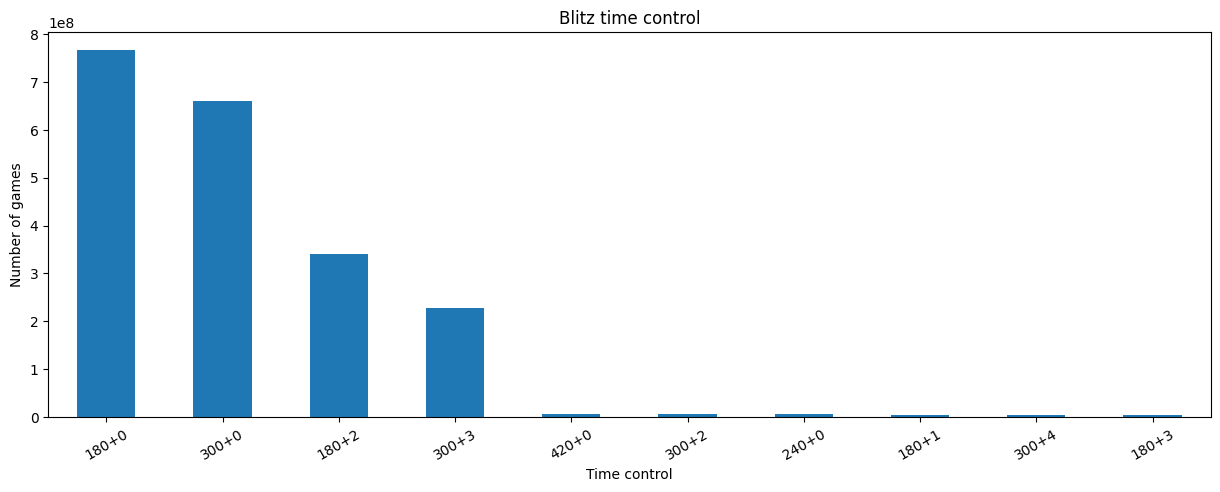

In [4]:
time_control_frequencies = blitz_games["TimeControl"].value_counts().compute()
axis = time_control_frequencies.head(10).plot.bar("bar", figsize=(15, 5))
plt.title("Blitz time control")
plt.xlabel("Time control")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

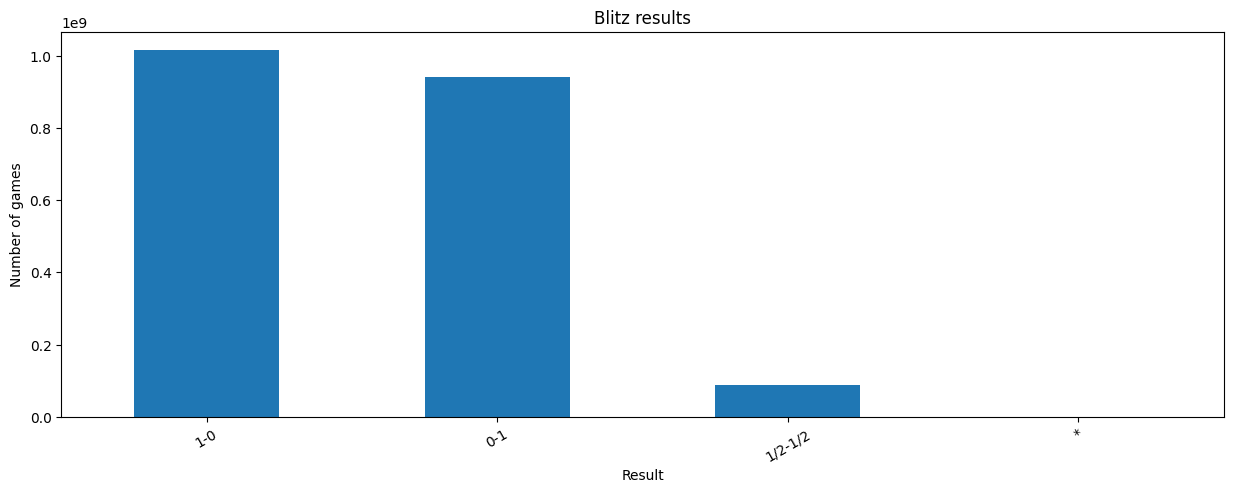

In [19]:
result_frequencies = blitz_games["Result"].value_counts().compute()
axis = result_frequencies.head(10).plot.bar("bar", figsize=(15, 5))
plt.title("Blitz results")
plt.xlabel("Result")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

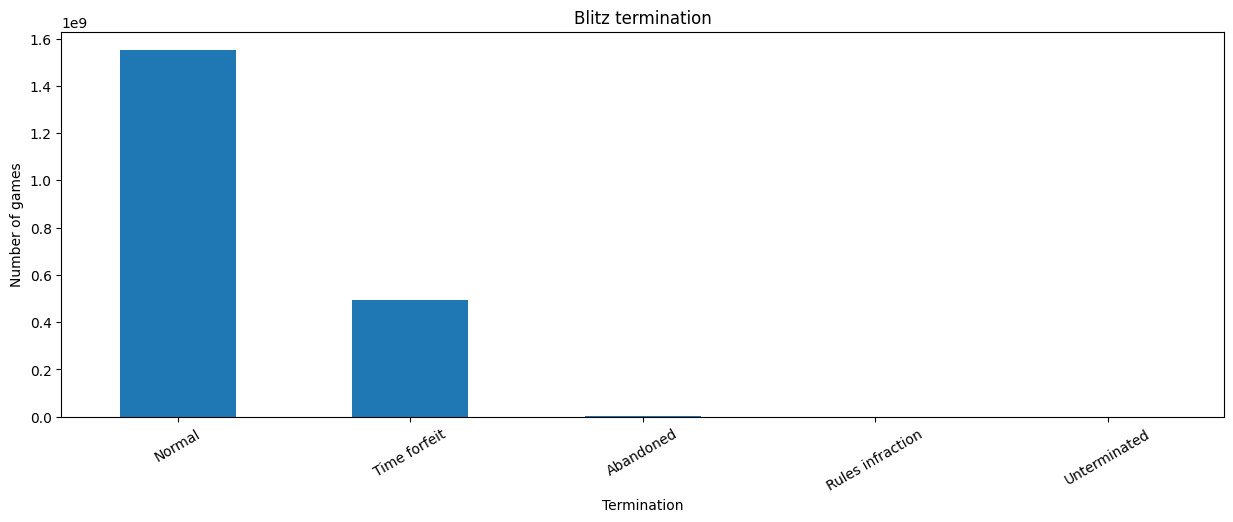

In [6]:
termination_frequencies = blitz_games["Termination"].value_counts().compute()
axis = termination_frequencies.head(10).plot.bar("bar", figsize=(15, 5))
plt.title("Blitz termination")
plt.xlabel("Termination")
plt.ylabel("Number of games")
plt.xticks(rotation=30)
plt.show()

In [17]:
blitz_games.describe(include=["uint16"]).compute()

,WhiteElo,BlackElo
count,2046867409,2046867409
mean,1619.444639,1619.382711
std,360.688706,360.808637
min,400,400
25%,1509.0,1506.0
50%,1719.0,1717.0
75%,1949.0,1949.0
max,3969,3996


In [5]:
time_controls = time_control_frequencies.head(10).index
for time_control in time_controls:
    result = blitz_games[blitz_games["TimeControl"] == time_control].describe(include=["uint16"]).compute()
    print(time_control)
    print(result)
    print()

180+0
          WhiteElo     BlackElo
count    765787607    765787607
mean   1736.398839  1736.327899
std     352.993908   353.126322
min            400          400
25%         1620.0       1625.0
50%         1855.0       1858.0
75%         2065.0       2066.0
max           3969         3996

300+0
          WhiteElo     BlackElo
count    660066819    660066819
mean   1536.087901  1536.036072
std     340.619989   340.708382
min            400          400
25%         1454.0       1453.0
50%         1669.0       1670.0
75%         1856.0       1857.0
max           3497         3491

180+2
          WhiteElo     BlackElo
count    339851558    339851558
mean   1641.768363  1641.818167
std     357.899319   358.012418
min            400          400
25%         1509.0       1511.0
50%         1752.0       1752.0
75%         2002.0       2002.0
max           3568         3268

300+3
          WhiteElo     BlackElo
count    227840193    227840193
mean   1441.155738  1441.364357
std     323.6

#### Elo over the months

In [3]:
dir = "data/headers/"
stats = dict()
for game_file in os.listdir(dir):
    if not game_file.endswith(".parquet.zstd"):
        continue
    date = game_file.replace(".parquet.zstd", "")
    df = dd.read_parquet(f"{dir}/{game_file}", compression="zstd")
    df = df[(df["WhiteElo"] > 0) & (df["BlackElo"] > 0)]
    df = df[df["Event"] == "Rated Blitz game"][["WhiteElo", "BlackElo"]]
    result = df.describe(include=["uint16"]).compute()
    stats[date] = result

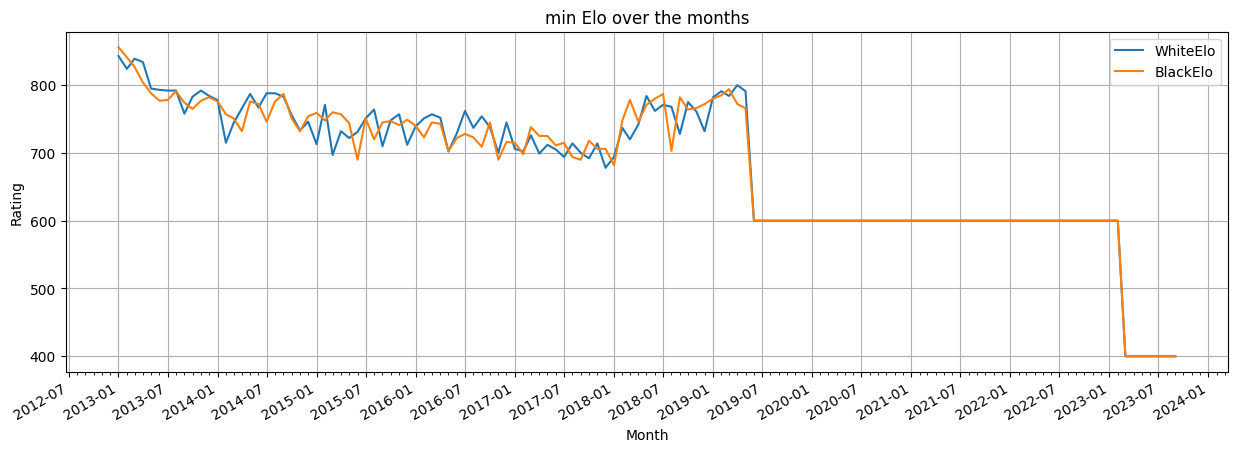

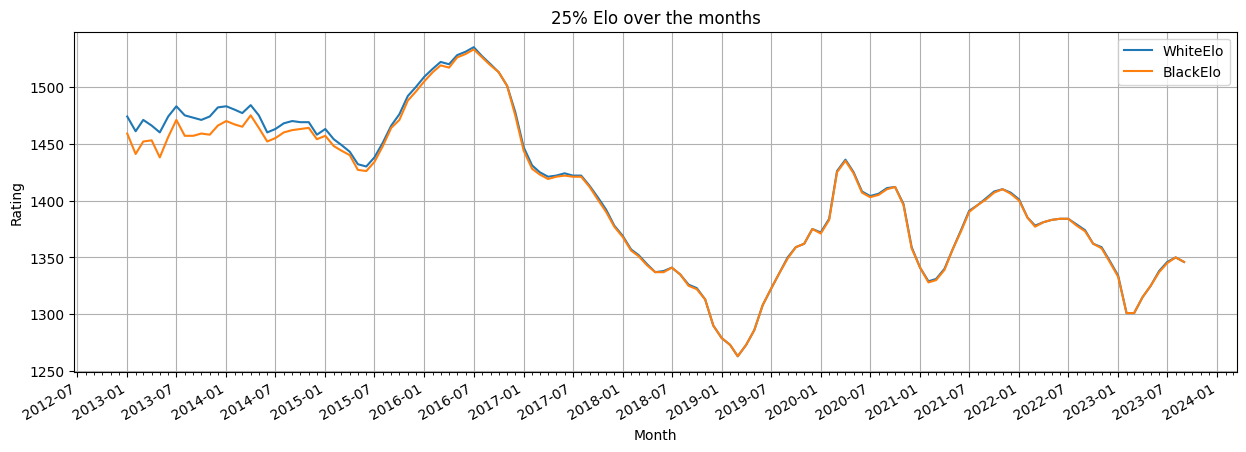

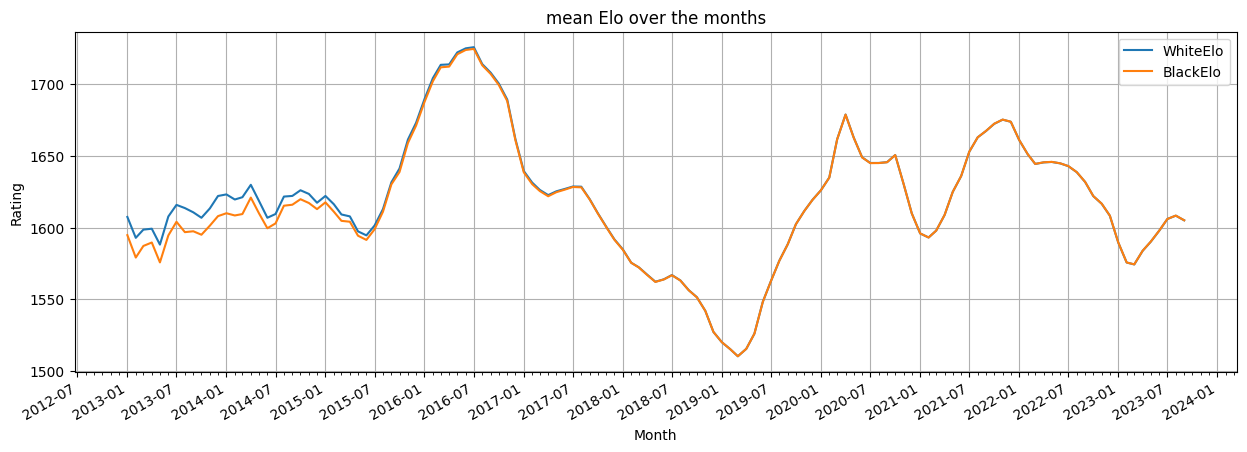

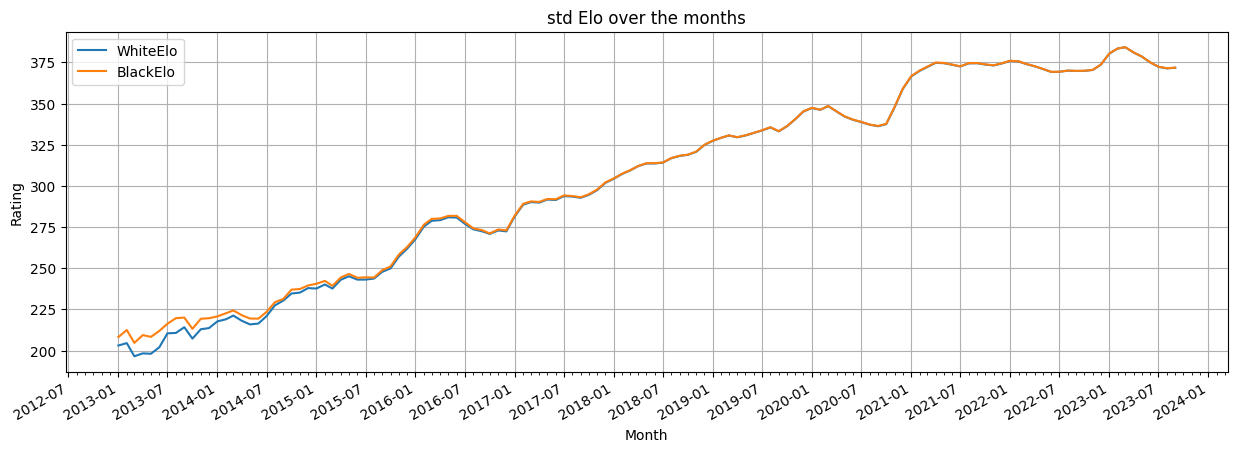

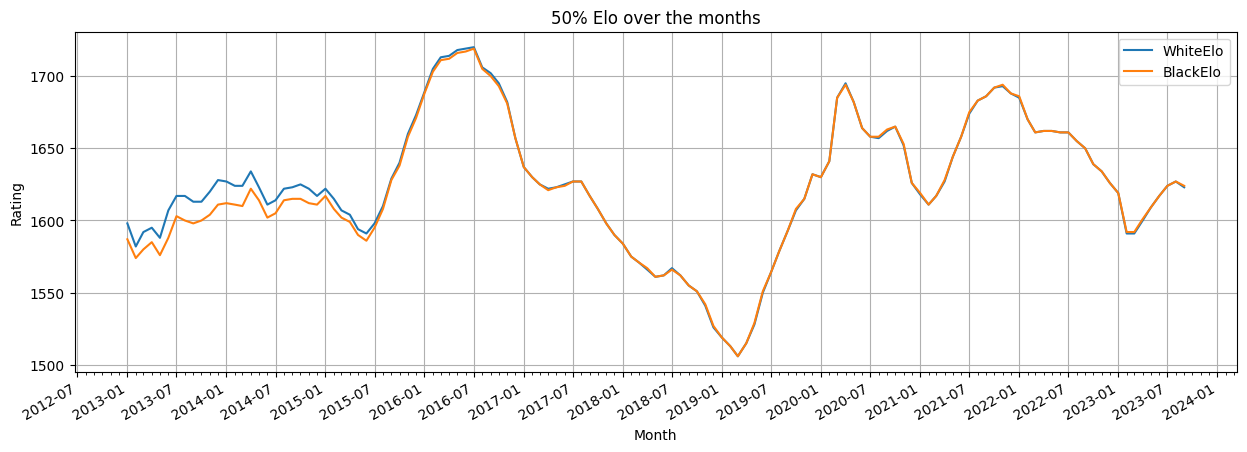

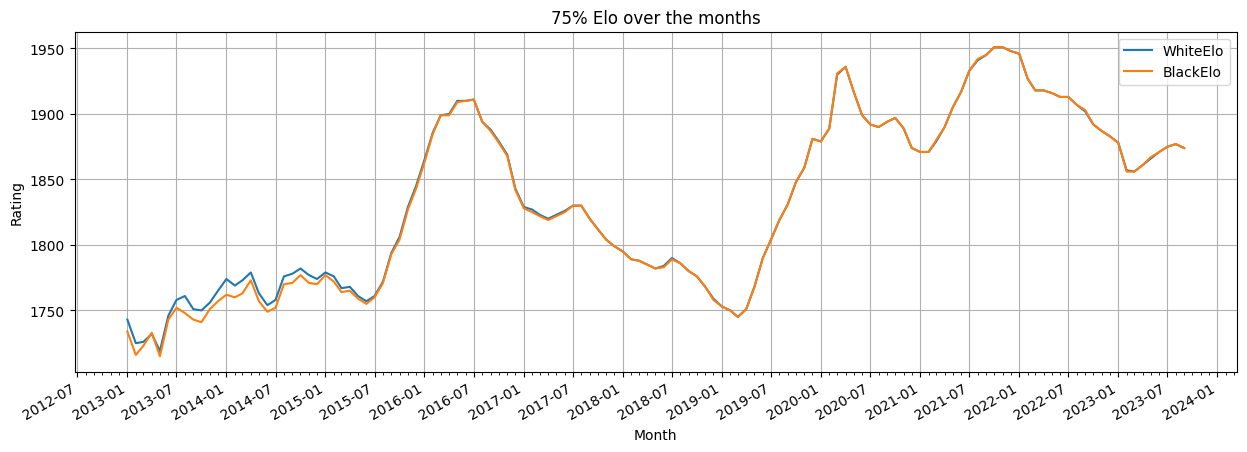

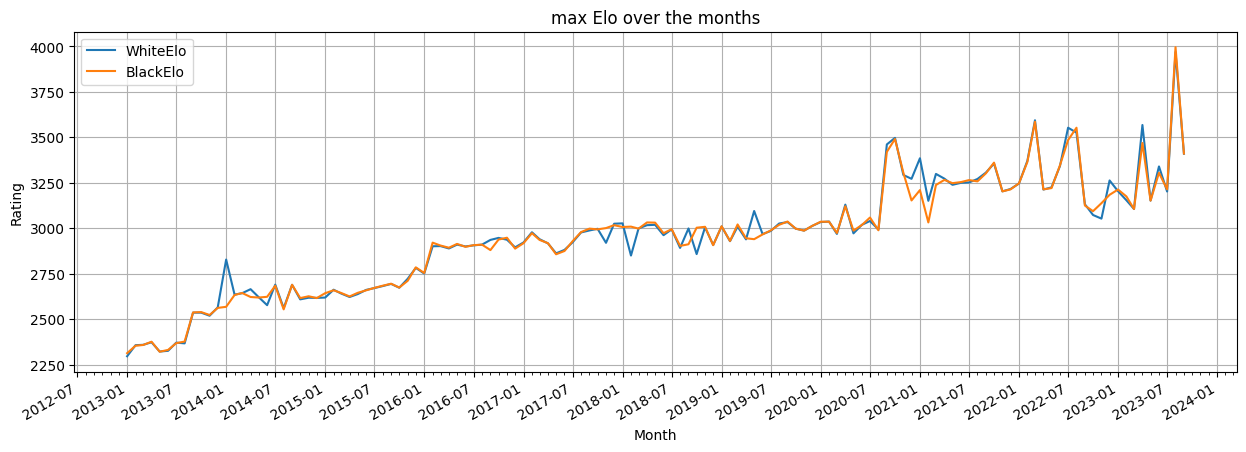

In [38]:
def construct_time_series_stats(stats, statistic):
    data = {
        "Date": list(),
        "WhiteElo": list(),
        "BlackElo": list()
    }
    for date in stats:
        white, black = stats[date].loc[statistic]
        data["Date"].append(date)
        data["WhiteElo"].append(white)
        data["BlackElo"].append(black)
    df = pd.DataFrame(data)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m")
    axis = df.plot(x="Date", y=["WhiteElo", "BlackElo"], figsize=(15, 5))
    axis.set_title(f"{statistic} Elo over the months")
    axis.set_xlabel("Month")
    axis.set_ylabel("Rating")
    axis.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.grid()

construct_time_series_stats(stats, "min")
construct_time_series_stats(stats, "25%")
construct_time_series_stats(stats, "mean")
construct_time_series_stats(stats, "std")
construct_time_series_stats(stats, "50%")
construct_time_series_stats(stats, "75%")
construct_time_series_stats(stats, "max")